<h1>Heart Disease UCI</h1>

<h3>Attribute Information</h3>

> 1. age 
> 2. sex 
> 3. chest pain type (4 values) 
> 4. resting blood pressure 
> 5. serum cholestoral in mg/dl 
> 6. fasting blood sugar > 120 mg/dl
> 7. resting electrocardiographic results (values 0,1,2)
> 8. maximum heart rate achieved 
> 9. exercise induced angina 
> 10. oldpeak = ST depression induced by exercise relative to rest 
> 11. the slope of the peak exercise ST segment 
> 12. number of major vessels (0-3) colored by flourosopy 
> 13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
The names and social security numbers of the patients were recently removed from the database, replaced with dummy values. One file has been "processed", that one containing the Cleveland database. All four unprocessed files also exist in this directory.


<h3>Objective</h3>

For the given attribute values the model need to predict the whether the patient is victim of heart disease or not  

<h3>References</h3>

1.https://www.kaggle.com/ronitf/heart-disease-uci

2.https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [1]:
#For Data loading and preprocessing
import pandas as pd

#For matrix operations
import numpy as np

#For plotting
import matplotlib.pyplot as plt
import seaborn as sns

#For splitting the data
from sklearn.model_selection import train_test_split

#For data preprocessing
from sklearn.preprocessing import StandardScaler

#For hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
#For appling LogisticRegression
from sklearn.linear_model import LogisticRegression

#For model/vatiable persistence 
from sklearn.externals import joblib

#For math operations
import math 

#To see the progress of the iterations
#from tqdm import tqdm

#Performance metrices
from sklearn.metrics import roc_auc_score,roc_curve,auc,log_loss,confusion_matrix

#For ignoring warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
data = pd.read_csv('heart_.csv')
print(data.shape)
data.head(5)

(1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


<h2>Exploratory Data Analysis</h2>

### 1. Check the data is balanced or not

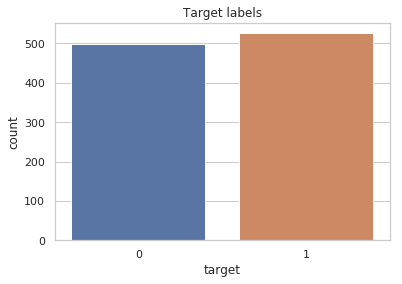

In [3]:
sns.set(style="whitegrid")
sns.countplot(data.target)
plt.title("Target labels")
plt.show()


#### Observation(s):  Data is not imbalanced 

<h2>2.Check for any outliers or Null values</h2>

In [4]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

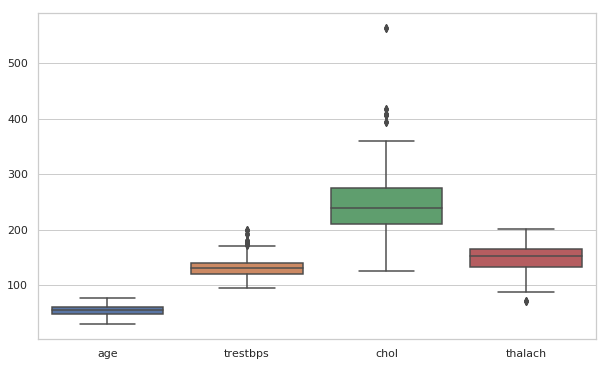

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['age','trestbps','chol','thalach']])

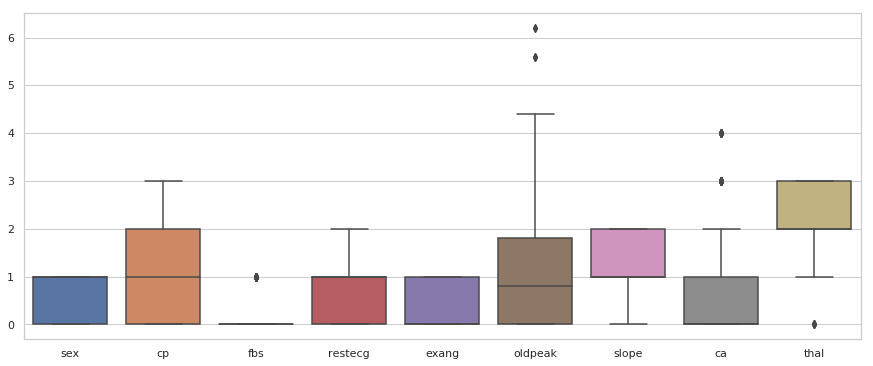

In [6]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=data[["sex","cp","fbs","restecg","exang","oldpeak","slope","ca","thal"]])

#### Observation(s):
1. From above two plots it is clear that data is not suffering from either outliers or Null values

<h2>Take a look at some important features</h2>

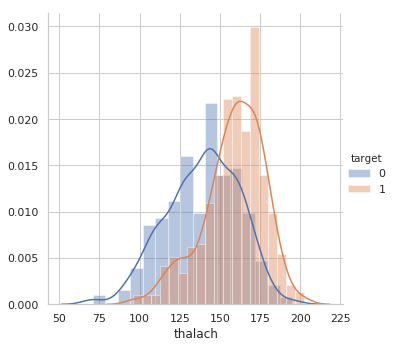

In [7]:
#Checking "(thalach) Maxmium heart rate feature"  

sns.FacetGrid(data, hue="target", size=5) \
   .map(sns.distplot, "thalach") \
   .add_legend();
plt.show();

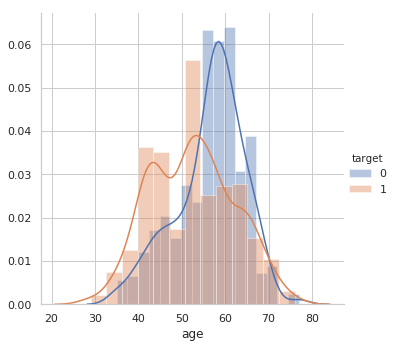

In [8]:
#As we know that "Age" is important factor in disease diagnosis. Hence cheking "age" feature   

sns.FacetGrid(data, hue="target", size=5) \
   .map(sns.distplot, "age") \
   .add_legend();
plt.show();

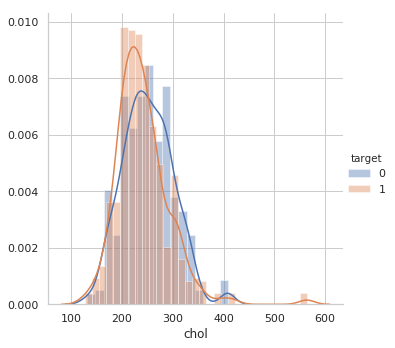

In [9]:
# Checking cholesterol feature
sns.FacetGrid(data, hue="target", size=5) \
   .map(sns.distplot, "chol") \
   .add_legend();
plt.show();

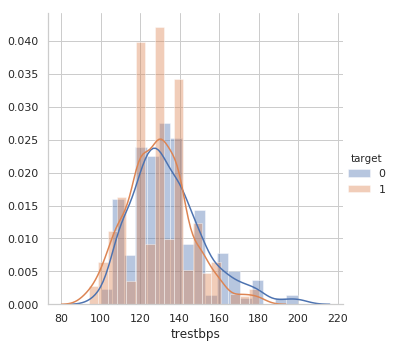

In [10]:
#Checking resting bloop pressure
sns.FacetGrid(data, hue="target", size=5) \
   .map(sns.distplot, "trestbps") \
   .add_legend();
plt.show();

<h2>3.Data Preprocessing</h2>

In [11]:
Y= data.target
data = data.drop(['target'],axis=1)

In [12]:
column_names = data.columns.tolist()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, Y, train_size=0.80,shuffle=False)

In [14]:
scaler= StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
def plotErrors(k,train,cv):
    plt.grid()   
    plt.plot(k, train, label='Train logloss')
    plt.plot(k, cv, label='CV logloss')
    plt.legend()
    plt.xlabel("log(C)= -log(λ)")
    plt.ylabel("Log Loss")
    plt.title("Error Plot for Train and Validation data")
    plt.show()

In [16]:
def evaluate_this_model(clf):
    print("Your model parameters are as below:\n")
    print(clf)
    print("-------------------------------------------------------------------------------")
    print("\nTest and train results for this model:")#\n --------------------------------------------------------")
    
    train_loss = log_loss(y_train, clf.predict_proba(X_train)[:,1])
    test_loss  =log_loss(y_test, clf.predict_proba(X_test)[:,1])
    print("\nLog_loss on train data is :{}".format(train_loss))
    print("Log_loss on test data is :{}\n ".format(test_loss))
    
    print("-------------------------------------------------------------------------------")

    """train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC for Train and Test data with best_fit")
    plt.grid()
    plt.show()
    print("-------------------------------------------------------------------------------")"""
    print("Weight vector for this model is :\n\n{}".format(clf.coef_[0]))
    print("-------------------------------------------------------------------------------")
    print("\nFeatures and its corresponding weights\n")
    feature_weights=sorted(zip(clf.coef_[0],column_names),reverse = True)
    [print(i) for i in feature_weights]

<h2> 3. Understanding Sklearn's Logisitic Regression</h2>

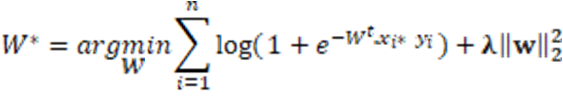

### Let's understand sklearns LR class on comparing with its objective function

In [17]:
clf = LogisticRegression()
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

###### This is the sklearn's LR class with all default values


#### 1. "C"

In [18]:
# 'λ' = 0.001 checking with small value
Lambda = 0.001
clf = LogisticRegression(C=1/Lambda ) 
clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.32719236812013447
Log_loss on test data is :0.45806777849211316
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[-0.12455692 -0.88948799  1.03216696 -0.26441447 -0.22509559 -0.07642303
  0.15700353  0.48174716 -0.49273085 -0.72781503  0.38949513 -0.85329497
 -0.63443058]
-------------------------------------------------------------------------------

Features and its corresponding weights

(1.0321669624904328, 'c

##### Observe the log-loss for test and train data sets, there is considerabe difference,  the model is working very well on train data but not on test data, which also called overfitting 

In [19]:
# 'λ' = 100000 checking with large value
Lambda = 100000
clf = LogisticRegression(C=1/Lambda) #instantiating LR into "clf" with lambda = 9000 (large value)
clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.6903127184269273
Log_loss on test data is :0.6907921143095112
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[-0.00097575 -0.00116028  0.00189554 -0.00060655 -0.00044206 -0.0002498
  0.0005475   0.00178048 -0.00181312 -0.00182101  0.00142233 -0.00161043
 -0.00139361]
-------------------------------------------------------------------------------

Features and its corresponding weights

(0.0018955434342797339, 'cp

###### Here the log loss is high in both test and train sets. This is also called underfitting  

 ###### 2. "fit_intercept" and "intercept_scaling"

In [20]:

Lambda = 100
clf = LogisticRegression(C=1/Lambda,intercept_scaling=0,fit_intercept=False) 
clf.fit(X_train, y_train)
#evaluate_this_model(clf)

print("Intercept value is: {} ".format(clf.intercept_))
print("\nAnd weights vaector is : ")
(clf.coef_[0])

Intercept value is: 0.0 

And weights vaector is : 


array([-0.11503898, -0.35612941,  0.46682107, -0.11094516, -0.07448729,
       -0.02244197,  0.09372189,  0.29787813, -0.3261558 , -0.35116857,
        0.22226229, -0.39779298, -0.32181629])

In [21]:

Lambda = 100
clf = LogisticRegression(C=1/Lambda,intercept_scaling=1,fit_intercept=True) 
clf.fit(X_train, y_train)
#evaluate_this_model(clf)

print("Intercept value is: {} ".format(clf.intercept_))
print("\nAnd weights vaector is : ")
(clf.coef_[0])

Intercept value is: [0.02812662] 

And weights vaector is : 


array([-0.1162764 , -0.35704289,  0.46627204, -0.1108161 , -0.07415849,
       -0.02243657,  0.09358206,  0.29687079, -0.32536579, -0.34947532,
        0.22238931, -0.39660736, -0.3211878 ])

In [22]:

Lambda = 100
clf = LogisticRegression(C=1/Lambda,intercept_scaling=100,fit_intercept=True) 
clf.fit(X_train, y_train)
#evaluate_this_model(clf)

print("Intercept value is: {} ".format(clf.intercept_))
print("\nAnd weights vaector is : ")
(clf.coef_[0])

Intercept value is: [0.04928081] 

And weights vaector is : 


array([-0.11722561, -0.35780248,  0.46593056, -0.11073453, -0.07392053,
       -0.02245998,  0.09351367,  0.29621549, -0.3248254 , -0.34831123,
        0.22246425, -0.39577759, -0.32080999])

In [23]:

Lambda = 100
clf = LogisticRegression(C=1/Lambda,intercept_scaling=10000000,fit_intercept=True) 
clf.fit(X_train, y_train)
#evaluate_this_model(clf)

print("Intercept value is: {} ".format(clf.intercept_))
print("\nAnd weights vaector is : ")
(clf.coef_[0])

Intercept value is: [0.0829744] 

And weights vaector is : 


array([-9.59706326e-15, -1.13704947e-14,  1.85981790e-14, -5.96488113e-15,
       -4.34813235e-15, -2.46043593e-15,  5.37956881e-15,  1.74926590e-14,
       -1.78053777e-14, -1.78886590e-14,  1.39798116e-14, -1.58015051e-14,
       -1.36750724e-14])

##### we can see that as we scale up the intercept, the prediction weights are decreasing

##### 3. "tol" (tolerance) and "max_iter"

In [24]:
#Default value for tolerance is tol=0.0001
Lambda = 100
clf = LogisticRegression(C=1/Lambda,tol=1) 
clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=1, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.4121313041362496
Log_loss on test data is :0.4732552200029832
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[-0.08697916 -0.2762315   0.35872764 -0.05795355 -0.03867474 -0.00777937
  0.07115102  0.23948599 -0.27709605 -0.25392417  0.16691816 -0.3019423
 -0.25689663]
-------------------------------------------------------------------------------

Features and its corresponding weights

(0.3587276354269305, 'cp')
(0.239

In [25]:
Lambda = 100
clf = LogisticRegression(C=1/Lambda, tol=1e-15 ) 
clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=1e-15, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.377080482519137
Log_loss on test data is :0.45023552385527704
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[-0.11627099 -0.35707662  0.46629302 -0.11083093 -0.07416935 -0.02245805
  0.0935981   0.29692583 -0.32536036 -0.34952112  0.22235793 -0.39662025
 -0.32122503]
-------------------------------------------------------------------------------

Features and its corresponding weights

(0.46629301711422655, 'cp')


In [26]:
Lambda = 100
clf = LogisticRegression(C=1/Lambda,max_iter =1000, tol=1e-3) 
clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.37708852725197956
Log_loss on test data is :0.45024117101913325
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[-0.1162764  -0.35704289  0.46627204 -0.1108161  -0.07415849 -0.02243657
  0.09358206  0.29687079 -0.32536579 -0.34947532  0.22238931 -0.39660736
 -0.3211878 ]
-------------------------------------------------------------------------------

Features and its corresponding weights

(0.4662720387604094, 'cp'

In [27]:
Lambda = 100
clf = LogisticRegression(C=1/Lambda,max_iter =1000, tol=3 ) 
clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=3, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.6931471805599453
Log_loss on test data is :0.6931471805599453
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-------------------------------------------------------------------------------

Features and its corresponding weights

(0.0, 'trestbps')
(0.0, 'thalach')
(0.0, 'thal')
(0.0, 'slope')
(0.0, 'sex')
(0.0, 'restecg')
(0.0, 'oldpeak')
(0.0, 'fbs')
(0.0, 'exang')
(0.0, 'cp')

#### Here i have given "tol = 3" which means we are stopping the algorithm at very first level hence we got all weights as zero

#### 4. solver

In [28]:
Lambda = 100
clf = LogisticRegression(C=1/Lambda,solver='saga') 
clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.37717630640012334
Log_loss on test data is :0.4506482877911682
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[-0.11723305 -0.3578128   0.46593193 -0.11074043 -0.07392851 -0.02247491
  0.0935308   0.29621871 -0.32482129 -0.34829004  0.22249142 -0.39577428
 -0.32079896]
-------------------------------------------------------------------------------

Features and its corresponding weights

(0.4659319298534034, 'cp')

In [29]:
Lambda = 100
clf = LogisticRegression(C=1/Lambda,solver='sag') 
clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.37717740005324063
Log_loss on test data is :0.45064831771781194
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[-0.11722073 -0.35779556  0.46592819 -0.11075112 -0.0739361  -0.02245614
  0.09350658  0.29621978 -0.32481814 -0.34829539  0.22247605 -0.39577887
 -0.32080447]
-------------------------------------------------------------------------------

Features and its corresponding weights

(0.4659281925267055, 'cp')

#### 5. Norms

In [30]:

Norm = "l2"  #("l2" is defult norm value)
Lambda = 100
clf = LogisticRegression(penalty=Norm) 
clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.3272500660326862
Log_loss on test data is :0.4557784556132889
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[-0.12507081 -0.86614257  1.00771308 -0.25750495 -0.21673291 -0.0719274
  0.15446321  0.47350503 -0.48723319 -0.71126393  0.38213128 -0.83413938
 -0.62157861]
-------------------------------------------------------------------------------

Features and its corresponding weights

(1.0077130839329096, 'cp')
(0

In [31]:
Norm = "l1" 
Lambda = 100
clf = LogisticRegression(penalty=Norm,C=1/Lambda) 
clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.5188669186735475
Log_loss on test data is :0.5568156702688732
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[ 0.          0.          0.27547823  0.          0.          0.
  0.          0.13354673 -0.16452246 -0.24577692  0.         -0.16697794
 -0.04882149]
-------------------------------------------------------------------------------

Features and its corresponding weights

(0.27547822502669744, 'cp')
(0.1335

##### Here we can understand that 'l1' norm creates more sparsity hence in above weight vector we can see more zeors for all unimportant features.  

In [32]:
Norm = "elasticnet" 
Lambda = 100
algo_style="saga"

clf = LogisticRegression(penalty=Norm,C=1/Lambda,l1_ratio =0.3,solver = algo_style) 

clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.3, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.41027184619693424
Log_loss on test data is :0.4785413650341346
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[-0.0456005  -0.24811603  0.40642771 -0.01408344  0.          0.
  0.00041553  0.24981487 -0.27572908 -0.31467832  0.15116438 -0.33749436
 -0.24879274]
-------------------------------------------------------------------------------

Features and its corresponding weights

(0.40642771334960104, 'cp')

In [33]:
Norm = "elasticnet" 
Lambda = 100
algo_style="saga"

clf = LogisticRegression(penalty=Norm,C=1/Lambda,l1_ratio =0.8,solver = algo_style) 

clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.8, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.4820535019386126
Log_loss on test data is :0.5304582574076304
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[ 0.         -0.07105154  0.31003507  0.          0.          0.
  0.          0.17972203 -0.19583914 -0.27538922  0.         -0.2170122
 -0.10967984]
-------------------------------------------------------------------------------

Features and its corresponding weights

(0.31003507447351525, 'cp')
(

In [34]:
Norm = "elasticnet" 
Lambda = 100
algo_style="saga"

clf = LogisticRegression(penalty=Norm,C=1/Lambda,l1_ratio =1,solver = algo_style) 

clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=1, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.5186741799721112
Log_loss on test data is :0.5588493053692344
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[ 0.          0.          0.27603951  0.          0.          0.
  0.          0.13388222 -0.16361969 -0.242395    0.         -0.16598348
 -0.04863948]
-------------------------------------------------------------------------------

Features and its corresponding weights

(0.27603950759479495, 'cp')
(0

##### 6. dual

In [35]:
Lambda =100
clf = LogisticRegression(C=1/Lambda,dual=True) 
clf.fit(X_train, y_train)
evaluate_this_model(clf)


Your model parameters are as below:

LogisticRegression(C=0.01, class_weight=None, dual=True, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.37708050512240476
Log_loss on test data is :0.4502355666426743
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[-0.11627082 -0.35707687  0.46629307 -0.11083062 -0.07416893 -0.02245782
  0.09359785  0.29692593 -0.32536016 -0.34952089  0.22235771 -0.39662016
 -0.32122508]
-------------------------------------------------------------------------------

Features and its corresponding weights

(0.46629306996743425, 'cp')

In [36]:
Lambda =100
clf = LogisticRegression(C=1/Lambda,dual=False) 
clf.fit(X_train, y_train)
evaluate_this_model(clf)


Your model parameters are as below:

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.37708852725197956
Log_loss on test data is :0.45024117101913325
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[-0.1162764  -0.35704289  0.46627204 -0.1108161  -0.07415849 -0.02243657
  0.09358206  0.29687079 -0.32536579 -0.34947532  0.22238931 -0.39660736
 -0.3211878 ]
-------------------------------------------------------------------------------

Features and its corresponding weights

(0.4662720387604094, 'cp'

###### 7. class_weight 

In [37]:
clf = LogisticRegression(class_weight = 'balanced') 
clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.32758117968983025
Log_loss on test data is :0.45552470161556524
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[-0.13009689 -0.87322448  1.00549446 -0.25670031 -0.22160594 -0.06800891
  0.1501708   0.4786306  -0.48389142 -0.70433315  0.38645041 -0.83938897
 -0.61900803]
-------------------------------------------------------------------------------

Features and its corresponding weights

(1.0054944626442306,

In [38]:
clf = LogisticRegression(class_weight = None) 
clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.3272500660326862
Log_loss on test data is :0.4557784556132889
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[-0.12507081 -0.86614257  1.00771308 -0.25750495 -0.21673291 -0.0719274
  0.15446321  0.47350503 -0.48723319 -0.71126393  0.38213128 -0.83413938
 -0.62157861]
-------------------------------------------------------------------------------

Features and its corresponding weights

(1.0077130839329096, 'cp')
(0

##### Here the data we have  is already balanced hence there no big advantage here by using class_weight parameter.

In [39]:
clf = LogisticRegression(class_weight ={1:1, 0:1}) 
clf.fit(X_train, y_train)
evaluate_this_model(clf)

Your model parameters are as below:

LogisticRegression(C=1.0, class_weight={0: 1, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
-------------------------------------------------------------------------------

Test and train results for this model:

Log_loss on train data is :0.3272500660326862
Log_loss on test data is :0.4557784556132889
 
-------------------------------------------------------------------------------
Weight vector for this model is :

[-0.12507081 -0.86614257  1.00771308 -0.25750495 -0.21673291 -0.0719274
  0.15446321  0.47350503 -0.48723319 -0.71126393  0.38213128 -0.83413938
 -0.62157861]
-------------------------------------------------------------------------------

Features and its corresponding weights

(1.0077130839329096, 

##### 8. n_jobs

In [40]:
clf = LogisticRegression(n_jobs=-1,verbose=-1) 
clf.fit(X_train, y_train)
#evaluate_this_model(clf)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=-1,
                   warm_start=False)

#### To find the appropriate parameter values,  we have a implemented cv algorithms from sklearn library . Now let's cross validate with setting some range of parameters at once 

In [41]:
parameters={'C':[10**-6,10**-5,10**-3,10**-4, 10**-2, 10**-1,10**0, 10**2, 10**3,10**4,10**5,10**6],
            'penalty':['l1','l2'],
            'tol':[0.0001,1e-4,1e-5,0.01],
            'fit_intercept':[True,False],
            'intercept_scaling':[0.1,0.01,1,10],
            'warm_start': [True,False]
            } #Setting all parameters in a single pipeline 

#log_c = list(map(lambda x : float(math.log(x)),parameters['C']))

clf_log = LogisticRegression(n_jobs=-1)

clf = GridSearchCV(clf_log, parameters, cv=5, scoring='neg_log_loss',return_train_score =True,n_jobs=-1,verbose=5)
clf.fit(X_train, y_train)

train_loss= clf.cv_results_['mean_train_score']
cv_loss = clf.cv_results_['mean_test_score'] 



Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1130 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 2642 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 4586 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 6962 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 7680 out of 7680 | elapsed:   40.2s finished


In [42]:
results= pd.DataFrame({"train_loss":train_loss,"cv_loss":cv_loss})
print ("Printing train and test loss that we got in every fit")
results

Printing train and test loss that we got in every fit


,cv_loss,train_loss
0,-0.693147,-0.693147
1,-0.693147,-0.693147
2,-0.693147,-0.693147
3,-0.693147,-0.693147
4,-0.693147,-0.693147
5,-0.693147,-0.693147
6,-0.693147,-0.693147
7,-0.693147,-0.693147
8,-0.692921,-0.692918
9,-0.692921,-0.692918


In [43]:
clf = clf.best_estimator_
clf


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=0.1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l1',
                   random_state=None, solver='warn', tol=0.01, verbose=0,
                   warm_start=False)

In [44]:

clf.fit(X_train, y_train)

train_loss = log_loss(y_train, clf.predict_proba(X_train)[:,1])
test_loss  =log_loss(y_test, clf.predict_proba(X_test)[:,1])


print("Log_loss on train data is :{}".format(train_loss))
print("Log_loss on test data is :{}".format(test_loss))

Log_loss on train data is :0.3278963703919748
Log_loss on test data is :0.4549224988639386


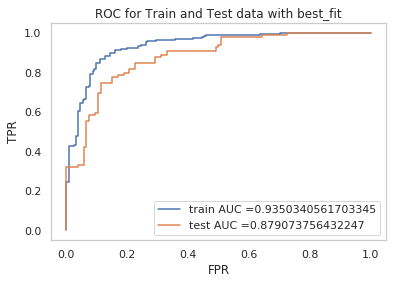

In [45]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

plt.grid()
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC for Train and Test data with best_fit")
plt.show()

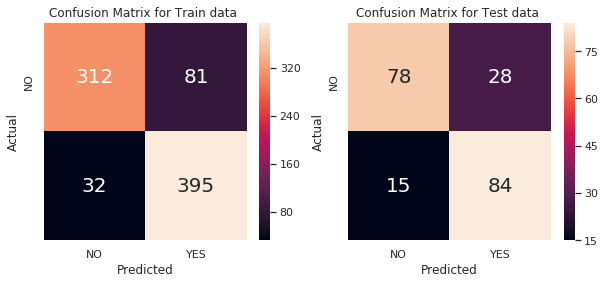

In [46]:
#ploting Confusion matrix
#Ref:https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
def plotcm (cm,ax,title):
    sns.heatmap(cm, ax=ax,annot=True,fmt='d',yticklabels=3,annot_kws={'size':20});
    ax.set_xlabel('Predicted');
    ax.set_ylabel('Actual'); 
    ax.set_title('Confusion Matrix for {} '.format(title)); 
    ax.xaxis.set_ticklabels(['NO', 'YES']); 
    ax.yaxis.set_ticklabels(['NO', 'YES']);


fig, subplt = plt.subplots(1, 2,figsize=(10, 4)) 
cm=confusion_matrix(y_train, clf.predict(X_train))
ax= subplt[0]
plotcm(cm,ax,'Train data')

cm=confusion_matrix(y_test, clf.predict(X_test))
ax= subplt[1]
plotcm(cm,ax,'Test data')

In [47]:
feature_weights=sorted(zip(clf.coef_[0],column_names),reverse = True)

In [48]:
feature_weights[:5]

[(0.9805394613335736, 'cp'),
 (0.4523779537598919, 'thalach'),
 (0.39376443709585435, 'slope'),
 (0.1410402267340785, 'restecg'),
 (-0.05642703146874516, 'fbs')]